In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + "/../")

import bfcnn
from bfcnn import load_image

2022-12-23 07:18:02.956017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 07:18:03.079537: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 07:18:03.079550: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 07:18:03.639482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
# setup environment
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.enable_eager_execution
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# setup variables

INPUT_SHAPE = (None, None, 1)

LAPLACIAN_CONFIG = {
    "levels": 3,
    "type": "laplacian",
    "xy_max": (1.0, 1.0),
    "kernel_size": (5, 5)
}

LEVELS = LAPLACIAN_CONFIG["levels"]

IMAGE_PATH = "../images/test/etc/lena.jpg"

In [4]:
# create input for pyramids
x = load_image(
        path=IMAGE_PATH,
        num_channels=1,
        expand_dims=True,
        normalize=True,
        image_size=(256, 256))
x = x * 2.0

In [5]:
pyramid_model = \
    bfcnn.build_pyramid_model(
        input_dims=INPUT_SHAPE,
        config=LAPLACIAN_CONFIG)

inverse_pyramid_model = \
    bfcnn.build_inverse_pyramid_model(
        input_dims=INPUT_SHAPE,
        config=LAPLACIAN_CONFIG)

x_pyramid = pyramid_model.predict(x)
x_recovered = inverse_pyramid_model.predict(x_pyramid)
x_error = np.abs(x_recovered - x)

2022-12-23 07:18:05,037 INFO pyramid.py:build_laplacian_pyramid_model:309] building laplacian pyramid model with: 3 levels
2022-12-23 07:18:05,067 INFO pyramid.py:build_inverse_laplacian_pyramid_model:365] building inverse laplacian pyramid model with: 3 levels


1/1 [==============================] - 0s 35ms/step


In [6]:
print(f"error: {np.mean(x_error)}")

error: 3.602886877729361e-10


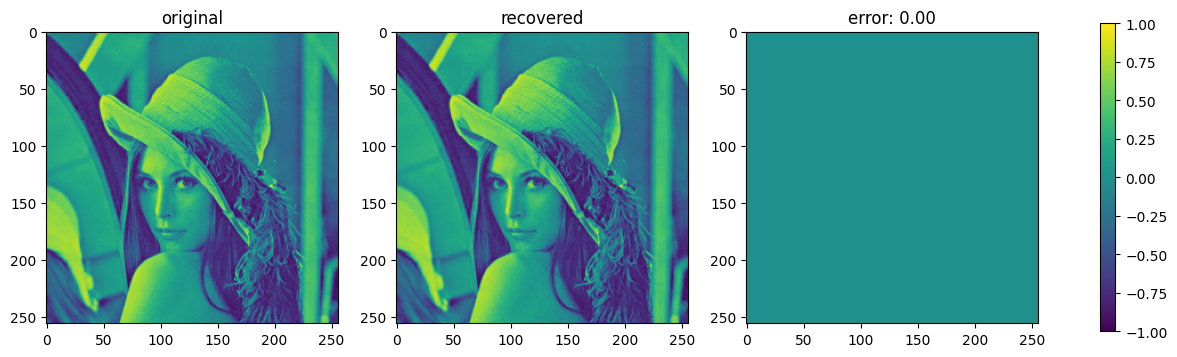

In [7]:
norm = plt.Normalize(-1,+1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
im = axes[0].imshow(x[0,:,:,0], norm=norm)
axes[0].set_title(f"original")
im = axes[1].imshow(x_recovered[0,:,:,0], norm=norm)
axes[1].set_title(f"recovered")
im = axes[2].imshow(x_error[0,:,:,0], norm=norm)
axes[2].set_title(f"error: {np.mean(x_error):0.02f}")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

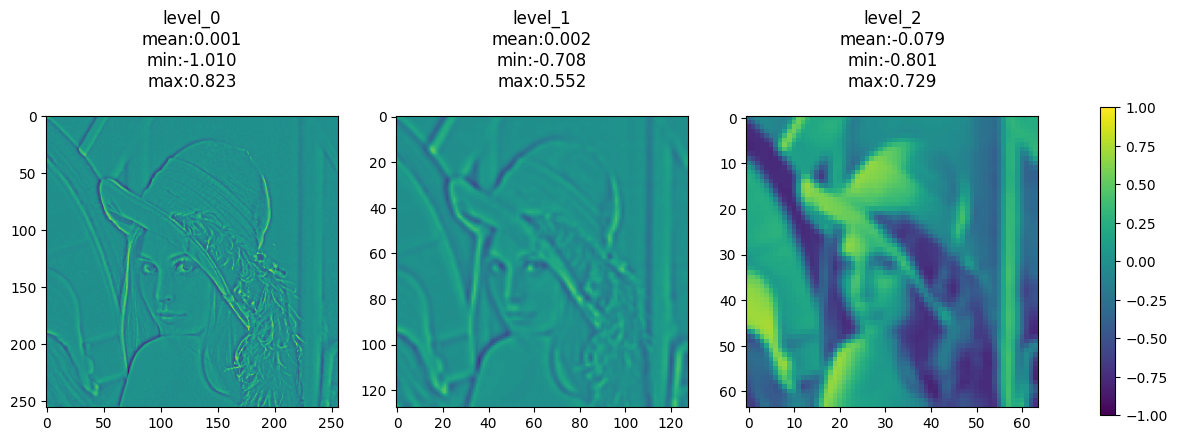

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=LEVELS, figsize=(16,4))
for i in range(LEVELS):
    x_mean_i = np.mean(x_pyramid[i])
    x_min_i = np.min(x_pyramid[i])
    x_max_i = np.max(x_pyramid[i])
    im = axes[i].imshow(x_pyramid[i][0,:,:,0], norm=norm)
    axes[i].set_title(
        f"level_{i}\n"
        f"mean:{x_mean_i:0.03f}\n"
        f"min:{x_min_i:0.03f}\n"
        f"max:{x_max_i:0.03f}\n")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

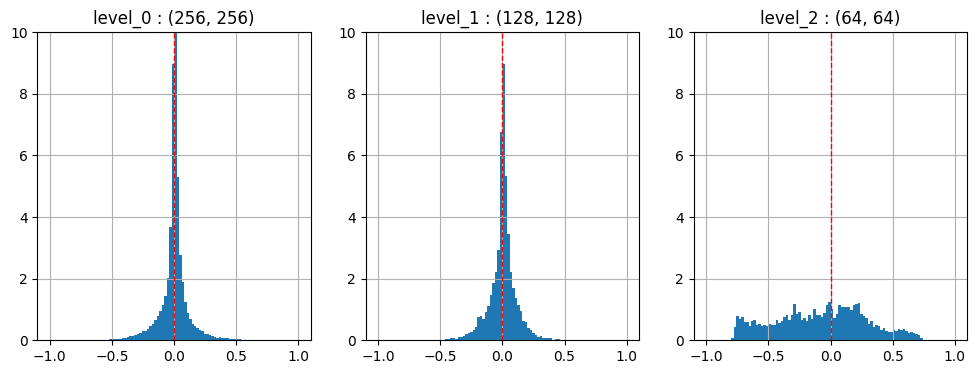

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=LEVELS, figsize=(12,4))
for i in range(LEVELS):
    x_mean_i = np.mean(x_pyramid[i])
    x_min_i = np.min(np.abs(x_pyramid[i]))
    x_max_i = np.max(np.abs(x_pyramid[i]))
    axes[i].hist(
        x = x_pyramid[i].flatten(),
        bins=100,
        density=True,
        range=(-1.0, +1.0))
    axes[i].axvline(
        x=0.0, color="red", linestyle="--", linewidth=1)
    axes[i].set_ylim((0.0, 10.0))
    axes[i].grid(True)
    axes[i].set_title(f"level_{i} : {x_pyramid[i].shape[1:3]}")
plt.show()

# Clip values

In [10]:
clip_value = 0.02
x_pyramid = pyramid_model.predict(x)
for i in range(LEVELS):
    x_pyramid[i][np.abs(x_pyramid[i]) < clip_value] = 0
x_recovered = inverse_pyramid_model.predict(x_pyramid)
x_error = np.abs(x_recovered - x)

1/1 [==============================] - 0s 18ms/step


In [11]:
print(f"error: {np.mean(x_error)}")

error: 0.00531742163002491


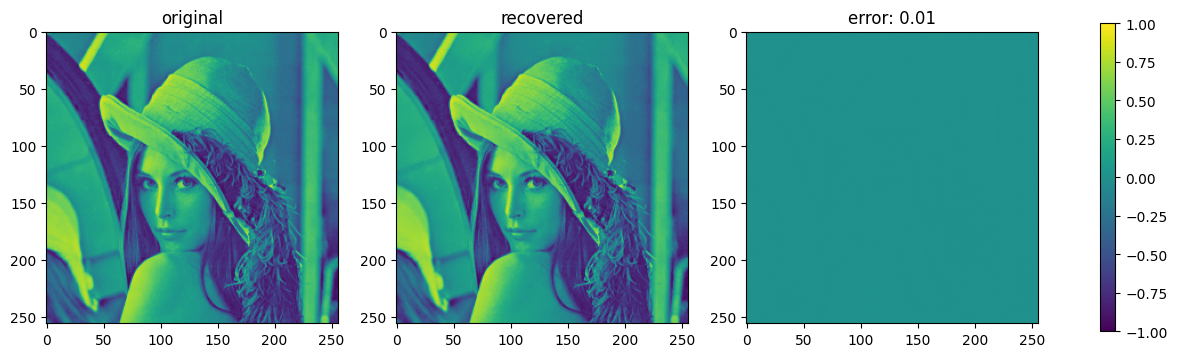

In [12]:
norm = plt.Normalize(-1,+1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
im = axes[0].imshow(x[0,:,:,0], norm=norm)
axes[0].set_title(f"original")
im = axes[1].imshow(x_recovered[0,:,:,0], norm=norm)
axes[1].set_title(f"recovered")
im = axes[2].imshow(x_error[0,:,:,0], norm=norm)
axes[2].set_title(f"error: {np.mean(x_error):0.02f}")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

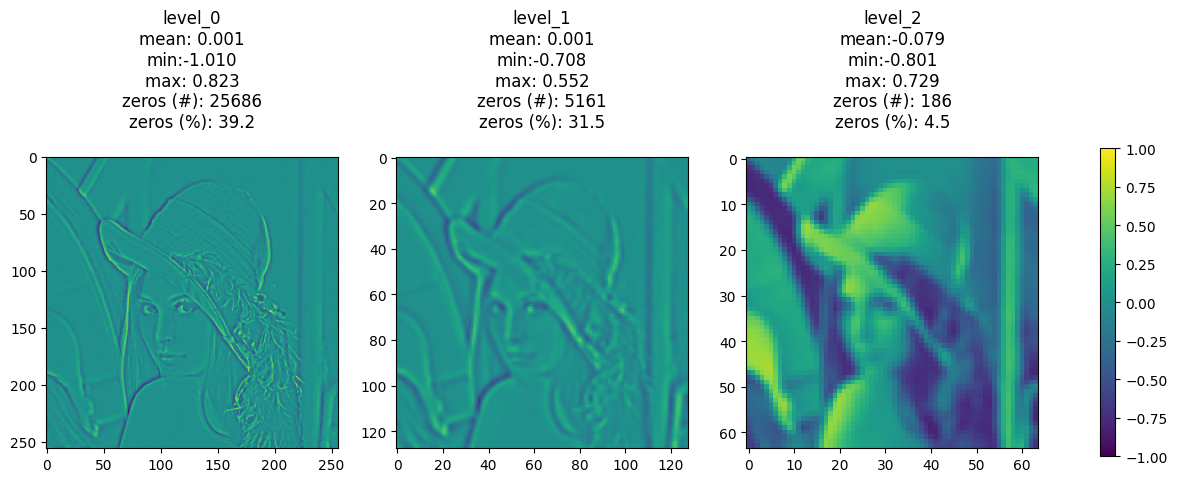

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=LEVELS, figsize=(16,4))
for i in range(LEVELS):
    x_mean_i = np.mean(x_pyramid[i])
    x_min_i = np.min(x_pyramid[i])
    x_max_i = np.max(x_pyramid[i])
    x_elements_i = x_pyramid[i].size
    x_zeros_i = x_elements_i - np.count_nonzero(x_pyramid[i])
    x_zeros_percentage_i = float(x_zeros_i) / float(x_elements_i) * 100
    im = axes[i].imshow(x_pyramid[i][0,:,:,0], norm=norm)
    axes[i].set_title(
        f"level_{i}\n"
        f"mean:{x_mean_i: 0.03f}\n"
        f"min:{x_min_i: 0.03f}\n"
        f"max:{x_max_i: 0.03f}\n"
        f"zeros (#):{x_zeros_i: 0.0f}\n"
        f"zeros (%):{x_zeros_percentage_i: 0.01f}\n")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

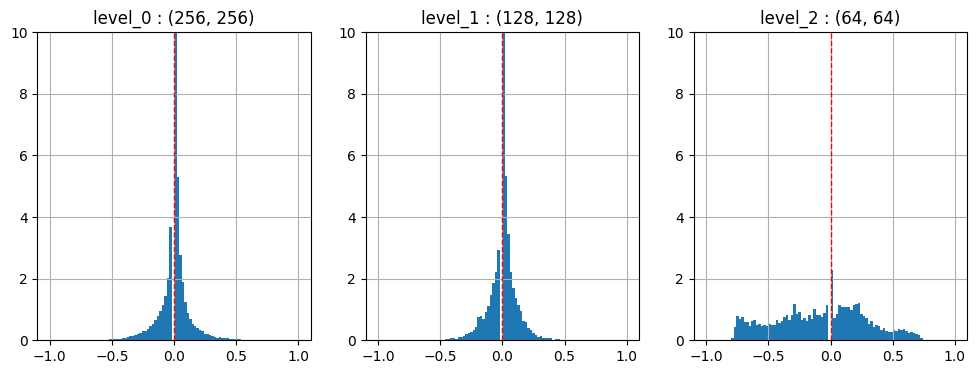

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=LEVELS, figsize=(12,4))
for i in range(LEVELS):
    x_mean_i = np.mean(x_pyramid[i])
    x_min_i = np.min(np.abs(x_pyramid[i]))
    x_max_i = np.max(np.abs(x_pyramid[i]))
    axes[i].hist(
        x = x_pyramid[i].flatten(),
        bins=100,
        density=True,
        range=(-1.0, +1.0))
    axes[i].axvline(
        x=0.0, color="red", linestyle="--", linewidth=1)
    axes[i].set_ylim((0.0, 10.0))
    axes[i].grid(True)
    axes[i].set_title(f"level_{i} : {x_pyramid[i].shape[1:3]}")
plt.show()